# *import*

In [1]:
# from collections import OrderedDict
from typing import List, Tuple, Optional, Dict, Union, Callable
import matplotlib.pyplot as plt
from datasets.utils.logging import enable_progress_bar
enable_progress_bar()
import time
import threading
import random
import os
os.environ["RAY_memory_usage_threshold"] = "0.8"
import torch


import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import EvaluateIns, EvaluateRes, FitIns, FitRes, Parameters, Scalar, ndarrays_to_parameters, parameters_to_ndarrays , NDArrays, Context, Metrics, MetricsAggregationFn    
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation

from base_FL.base_model import Net
from base_FL.train_test import test
from base_FL.base_loaddata import get_cached_datasets
from base_FL.utils import get_parameters, set_parameters, evaluate_and_plot_confusion_matrix

from base_FL.base_history import history
from base_FL.base_client import FlowerClient
from base_FL.base_clientmanger import DynamicClientManager
from base_FL.base_strategy import MyFedAvg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
# disable_progress_bar()

Training on cuda
Flower 1.17.0 / PyTorch 2.5.1+cu124


# **Load Data**

In [2]:
NUM_CLIENTS = 10
FRACTION = 0.5
BATCH_SIZE = 64
NUM_ROUNDS = 50
NUM_EPOCHS = 5
NUM_WORKERS = 8
VERBOSE = False
ATTACK_NUMS = 4
ATTACK_TYPE = "TPA"
DFL = False
Q = 0.0

In [3]:
# trainloader, _, _ = get_cached_datasets(partition_id=0, num_partitions=NUM_CLIENTS, q=Q)
# batch = next(iter(trainloader))
# images, labels = batch["img"], batch["label"]

# # Reshape and convert images to a NumPy array
# # matplotlib requires images with the shape (height, width, 3)
# images = images.permute(0, 2, 3, 1).numpy()

# # Denormalize
# images = images / 2 + 0.5

# # Create a figure and a grid of subplots
# fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# # Loop over the images and plot them
# for i, ax in enumerate(axs.flat):
#     ax.imshow(images[i])
#     ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    
#     ax.axis("off")

# # Show the plot
# fig.tight_layout()
# plt.show()

# **my fumction**

## **dynamic control**

In [4]:
current_server_round = 0
new_round_event = threading.Event()

def get_current_round() -> int:
    return current_server_round

In [5]:
def base_on_off(
    client_manager: DynamicClientManager,
    current_round,
    online_list: List[str],
    offline_list: List[str],
):
    # 下線部分在線客戶端        
    if current_round<4 and online_list and DFL:
        offline_num = 1
        for cid in random.sample(online_list, offline_num):
            client = client_manager.clients.get(cid)
            if client:
                client_manager.unregister(client)

    # 上線部分離線客戶端
    if current_round>3 and offline_list and DFL:
        online_num = 1
        for cid in random.sample(offline_list, online_num):
            client = client_manager.off_clients.get(cid)
            if client:
                print(f"[TOGGLER] 將 {cid} 上線")
                client_manager.register(client)

In [6]:
def random_on_off(
    client_manager: DynamicClientManager,
    current_round,
    online_list: List[str],
    offline_list: List[str],
    offline_rate: float = 0.3,
    online_rate: float = 0.3
):
    try:
        # 確保列表不為空
        if not online_list or not offline_list:
            print(f"警告: 客戶端列表為空 (在線:{len(online_list)}, 離線:{len(offline_list)})")
        
        # 下線部分在線客戶端
        if current_round % 2 != 0 and online_list and DFL:
            # 確保取樣數量不超過列表長度
            # offline_num = min(1, len(online_list))
            offline_num = 1
            if offline_num > 0:
                for cid in random.sample(online_list, offline_num):
                    client = client_manager.clients.get(cid)
                    if client:
                        client_manager.unregister(client)
        
        # 上線部分離線客戶端
        if current_round % 2 == 0 and offline_list and DFL:
            # 確保取樣數量不超過列表長度
            # online_num = min(1, len(offline_list))
            online_num = 1
            if online_num > 0:
                for cid in random.sample(offline_list, online_num):
                    client = client_manager.off_clients.get(cid)
                    if client:
                        print(f"[TOGGLER] 將 {cid} 上線")
                        client_manager.register(client)
    except Exception as e:
        print(f"random_on_off 執行錯誤: {e}")
        import traceback
        traceback.print_exc()

In [7]:
def background_online_offline_simulator(
    client_manager: DynamicClientManager,
    get_round: Callable[[], int],
    event: threading.Event,
    # interval: int = 30,
    offline_rate: float = 0.3,
    online_rate: float = 0.2
):
    while True:
        event.wait()  # 等待 server 通知新的一輪開始
        # time.sleep(interval)
        current_round = get_round()
        
        online_list = list(client_manager.online_clients)
        offline_list = list(client_manager.offline_clients)

        # base_on_off(client_manager, current_round, online_list, offline_list)
        random_on_off(client_manager, current_round, online_list, offline_list, offline_rate, online_rate)

        event.clear()  # 清除標記，等待下一次 signal

# **Client**

In [8]:
def client_fn(context: Context) -> Client:
    # Load model
    net = Net().to(DEVICE, memory_format=torch.channels_last)
    
    # Read the node_config to fetch data partition associated to this node
    partition_id = str(context.node_config["partition-id"])  # 強制轉換為字串
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = get_cached_datasets(partition_id, num_partitions=NUM_CLIENTS, q=Q)

    # # 加入除錯輸出
    # print(f"Partition ID: {partition_id}, ATTACK_NUMS: {ATTACK_NUMS}")
    # print(f"Condition check: {int(partition_id)} < {ATTACK_NUMS} = {int(partition_id) < ATTACK_NUMS}")

    if int(partition_id) < ATTACK_NUMS:
        print("Attacker:", partition_id)
        return FlowerClient(partition_id, net, trainloader, valloader, ATTACK_TYPE).to_client()
    else:
        # print("Normal client:", partition_id)
        return FlowerClient(partition_id, net, trainloader, valloader, None).to_client()

In [9]:
# Create the ClientApp
client = ClientApp(client_fn=client_fn)

# **Server**

### setting

In [10]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = []
    examples = []
    for num_examples, m in metrics:
        if "client_accuracy" not in m:
            print(f"Warning: Missing 'client_accuracy' in metrics for client")
            continue
        accuracies.append(num_examples * m["client_accuracy"])
        examples.append(num_examples)
    total_examples = sum(examples)
    if total_examples <= 0:
        print("Warning: No valid examples for aggregation. Returning 0.0")
        return {"accuracy": 0.0}
    return {"accuracy": sum(accuracies) / total_examples}

In [11]:
def server_evaluate(server_round, parameters, config):
    global current_server_round
    # 更新全域變數，讓背景執行緒知道目前是第幾個 round
    current_server_round = server_round
    """Evaluate the global model after each round (不再畫 confusion matrix)."""
    start_time = time.time()  # 記錄開始時間
    net = Net().to(DEVICE)
    set_parameters(net, parameters)

    # 加載測試集
    _, _, testloader = get_cached_datasets(0, num_partitions=NUM_CLIENTS, q=Q)

    # 測試
    loss, accuracy = test(net, testloader)
    
    end_time = time.time()  # 記錄結束時間
    round_time = end_time - start_time  # 計算 round 時間
    
    history.add_loss_centralized(server_round, loss)
    history.add_metrics_centralized(server_round, {"accuracy": accuracy})

    # 只記錄最終模型，不畫 confusion matrix
    if server_round == NUM_ROUNDS:  # 最後一輪才返回模型
        evaluate_and_plot_confusion_matrix(net, testloader, DEVICE)
        return loss, {"accuracy": accuracy}
    new_round_event.set()
    return loss, {"accuracy": accuracy}


In [12]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        # "local_epochs": 1 if server_round < 2 else NUM_EPOCHS,
        "local_epochs": NUM_EPOCHS,
        "train_mode": "lookahead",
    }
    return config

In [13]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())
param_count = sum(p.numel() for p in Net().parameters() if p.requires_grad)
print(f"Trainable Parameters: {param_count:,d}")
# Create FedAvg strategy
strategy = MyFedAvg(
    fraction_fit=FRACTION,  # Sample 100% of available clients for training
    fraction_evaluate=FRACTION,  # Sample 50% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than 10 clients for training
    min_evaluate_clients=NUM_CLIENTS,  # Never sample less than 5 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 10 clients are available
    initial_parameters=ndarrays_to_parameters(params),  # Pass initial model parameters
    evaluate_fn=server_evaluate,  # 設定 evaluate_fn
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
    on_evaluate_config_fn=fit_config
)

Trainable Parameters: 620,810


### Define Server

In [14]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour."""
    global testloader
    _, _, testloader = get_cached_datasets(0, num_partitions=NUM_CLIENTS, q=Q)

    # 設定 ServerConfig，如同你的程式碼
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    # 建立動態管理器
    client_manager = DynamicClientManager()
        
    # 建立並啟動背景執行緒，模擬客戶端動態上/下線
    simulator_thread = threading.Thread(
        target=background_online_offline_simulator,
        args=(client_manager, get_current_round, new_round_event),  # interval=30秒, toggle_rate=0.3
        daemon=True  # 設 daemon=True 可以在主程式結束時自動退出
    )
    simulator_thread.start()

    return ServerAppComponents(
        strategy=strategy,
        config=config,
        client_manager=client_manager,
    )


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

# *Run simulation*

### Run setting

In [15]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 2 , 
                                           "num_gpus": 0.2 #if (NUM_CLIENTS*FRACTION)>40 else 2/(NUM_CLIENTS*FRACTION)
                                          }}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

[Tue Jun 24 22:25:13 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0


INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


[Status] Client 12669044262492847067 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 3466498319639451239 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 4761010521416713703 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 6885719769663670892 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 15763090955182688748 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 3497543143727167541 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 7041294541072095539 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 13427747129940638836 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 13377127725846733525 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓
[Status] Client 1841247799402338047 已上線 ✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓✓


INFO :      initial parameters (loss, other metrics): 0.03620023965835571, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) [Tue Jun 24 22:25:47 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0
(ClientAppActor pid=224167) Attacker: 0
(ClientAppActor pid=224166) [Tue Jun 24 22:25:47 2025] 初始化聯邦數據集: mnist, 分區數=10, q=0.0 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.03872912745475769, {'accuracy': 0.1032}, 41.20983638300095)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.025496056020259856, {'accuracy': 0.4336}, 50.39162678801222)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.013779506379365921, {'accuracy': 0.8168}, 59.34102851402713)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.01346190754175186, {'accuracy': 0.8029}, 68.41254928498529)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.011986484169960022, {'accuracy': 0.8342}, 77.57970489701256)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.010900959035754203, {'accuracy': 0.8575}, 86.7530344609986)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.011353720054030418, {'accuracy': 0.8599}, 95.83090382500086)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.01130446075797081, {'accuracy': 0.8542}, 104.99568822898436)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.013559682422876357, {'accuracy': 0.773}, 114.06539380503818)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.010923262852430343, {'accuracy': 0.8693}, 124.32583726802841)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (11, 0.012303329157829284, {'accuracy': 0.8101}, 133.28777461498976)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (12, 0.013389191091060638, {'accuracy': 0.8288}, 142.24742714699823)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (13, 0.011856542301177978, {'accuracy': 0.8756}, 151.30497596599162)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (14, 0.013155493372678757, {'accuracy': 0.8278}, 160.47091683803592)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (15, 0.012293027013540268, {'accuracy': 0.8385}, 169.65293587301858)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (16, 0.010701251220703124, {'accuracy': 0.8557}, 178.9383574250387)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (17, 0.011396060585975648, {'accuracy': 0.875}, 188.1199228920159)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (18, 0.009806449618935585, {'accuracy': 0.8764}, 197.0969486440299)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (19, 0.009970474550127983, {'accuracy': 0.8733}, 205.9575687670149)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (20, 0.011408249735832215, {'accuracy': 0.8634}, 215.11597142199753)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (21, 0.012108385449647903, {'accuracy': 0.8422}, 224.20047999802046)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (22, 0.013317142742872238, {'accuracy': 0.8273}, 233.16348058899166)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (23, 0.013503758895397186, {'accuracy': 0.838}, 242.2155383680365)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (24, 0.012391706883907318, {'accuracy': 0.8487}, 251.27743422798812)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (25, 0.01230289478302002, {'accuracy': 0.8572}, 260.1569491419941)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (26, 0.014771852654218674, {'accuracy': 0.8172}, 269.3444166480331)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (27, 0.01314658539891243, {'accuracy': 0.831}, 278.3195205540396)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (28, 0.013667552852630615, {'accuracy': 0.8298}, 287.18367841403233)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (29, 0.011071211194992065, {'accuracy': 0.8704}, 296.37143508601)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (30, 0.01393808718919754, {'accuracy': 0.84}, 305.444372723985)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (31, 0.010947549653053284, {'accuracy': 0.866}, 314.72345762402983)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (32, 0.012112164640426635, {'accuracy': 0.8469}, 323.71753299003467)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (33, 0.012723676985502244, {'accuracy': 0.8424}, 333.6875060060411)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (34, 0.014234976905584335, {'accuracy': 0.8159}, 342.85196721804095)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (35, 0.012268300133943557, {'accuracy': 0.851}, 352.405673886009)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (36, 0.013079928743839264, {'accuracy': 0.838}, 361.6686511900043)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (37, 0.011290331304073333, {'accuracy': 0.8623}, 370.7614981420338)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (38, 0.014096126973628997, {'accuracy': 0.8527}, 379.7395452450146)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (39, 0.012322358167171478, {'accuracy': 0.8494}, 389.1188949170173)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (40, 0.012529024356603623, {'accuracy': 0.8535}, 398.1863304130384)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (41, 0.011741710805892945, {'accuracy': 0.8538}, 407.46868282201467)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (42, 0.014073715406656265, {'accuracy': 0.8396}, 416.5417605480179)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (43, 0.012995537370443344, {'accuracy': 0.8619}, 425.6086937910295)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (44, 0.011582594978809356, {'accuracy': 0.856}, 434.88402082701214)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (45, 0.010767518043518066, {'accuracy': 0.87}, 443.96385509101674)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (46, 0.012176512968540191, {'accuracy': 0.8631}, 453.1333844870096)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (47, 0.012987243461608887, {'accuracy': 0.8687}, 462.2037507360219)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224163) Attacker: 2 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (48, 0.010619860112667084, {'accuracy': 0.8714}, 471.2641469480004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 1 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (49, 0.013594977229833603, {'accuracy': 0.8303}, 480.6530335760326)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


警告: 客戶端列表為空 (在線:10, 離線:0)
(ClientAppActor pid=224165) Attacker: 0 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures


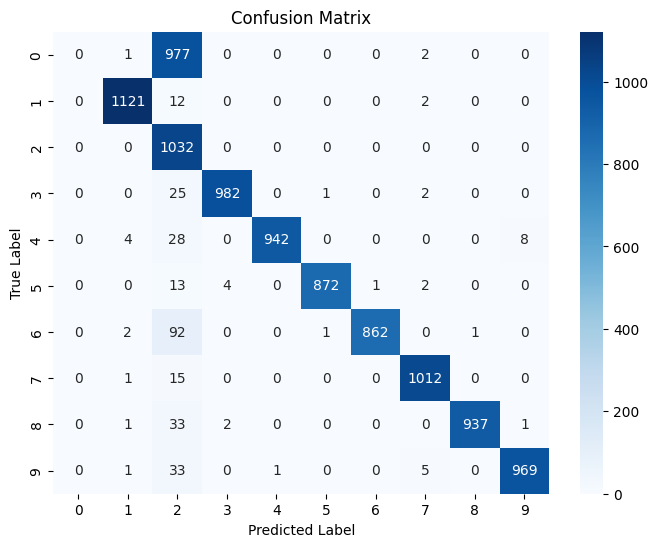

INFO :      fit progress: (50, 0.011535010290145874, {'accuracy': 0.8705}, 490.14315119502135)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=224163) Attacker: 3 [repeated 8x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 490.95s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03938427736157161
INFO :      		round 2: 0.026001860570958726
INFO :      		round 3: 0.014091099478711197
INFO :      		round 4: 0.01373692083045182
INFO :      		round 5: 0.012191085795611921
INFO :      		round 6: 0.011124384405947187
INFO :      		round 7: 0.011549094570749529
INFO :      		round 8: 0.011438605370312932
INFO :      		round 9: 0.013759927294741134
INFO :      		round 10: 0.011092926764849114
INFO :      		round 11: 0.01251895524265303
INFO :      		round 12: 0.013592117794529675
INFO :      		round 13: 0.012040685633762012
INFO :      		round 14: 0.013419306353611823
INFO :      		round 15: 0.012461317750379336
INFO :      		round 16: 0.010840093228434945
INFO :      		round 17: 0.011523669256751827
INFO :      		round 18: 0.009921597887597724
INFO :    

(ClientAppActor pid=224167) Attacker: 0 [repeated 3x across cluster]
Total Training Time: 524.88 seconds


In [16]:
# 讓 Flower 運行完整的 FL 訓練
start_time = time.time()  # 記錄開始時間

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

end_time = time.time()  # 記錄結束時間
total_time = end_time - start_time  # 計算總時間

print(f"Total Training Time: {total_time:.2f} seconds")  # 顯示總時間

### Loss 和 Accuracy 折線圖

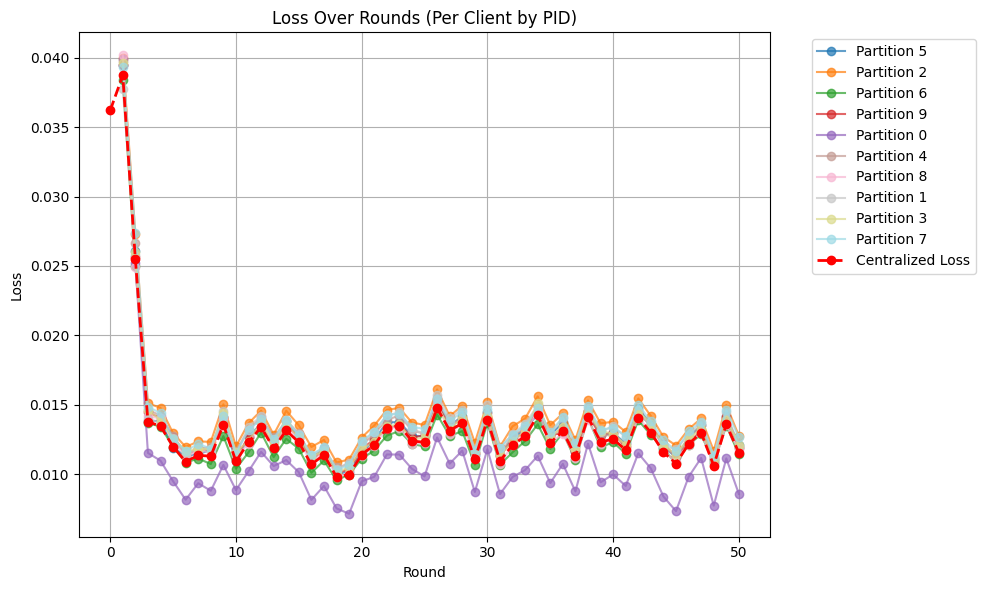

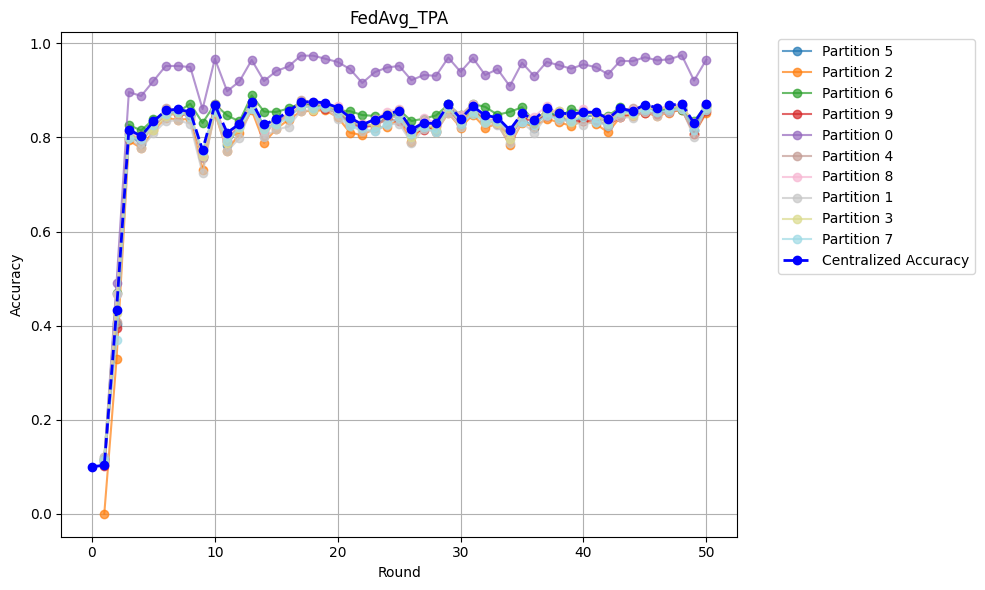

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 提取每個 client（按 pid）的 loss 和 accuracy 數據
client_losses = {}  # {pid: [(round, loss), ...]}
client_accuracies = {}  # {pid: [(round, acc), ...]}

for round_num, pid, loss in history.losses_distributed:
    if pid not in client_losses:
        client_losses[pid] = []
    client_losses[pid].append((round_num, loss))

for round_num, pid, acc in history.metrics_distributed.get('accuracy', []):
    if pid not in client_accuracies:
        client_accuracies[pid] = []
    client_accuracies[pid].append((round_num, acc))

# 為圖表生成隨機顏色
colors = plt.cm.tab20(np.linspace(0, 1, max(len(client_losses), len(client_accuracies))))

# 繪製每個 client 的 Loss 圖
plt.figure(figsize=(10, 6))
for idx, (pid, losses) in enumerate(client_losses.items()):
    rounds = [r for r, _ in sorted(losses)]
    loss_values = [l for _, l in sorted(losses)]
    plt.plot(rounds, loss_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed loss
rounds_loss = [t[0] for t in history.losses_centralized]
loss_values_centralized = [t[1] for t in history.losses_centralized]

distributed_loss_by_round = {}
for round_num, _, loss in history.losses_distributed:
    if round_num not in distributed_loss_by_round:
        distributed_loss_by_round[round_num] = []
    distributed_loss_by_round[round_num].append(loss)
rounds_loss_distributed = sorted(distributed_loss_by_round.keys())
loss_values_distributed = [np.mean(distributed_loss_by_round[r]) for r in rounds_loss_distributed]

plt.plot(rounds_loss, loss_values_centralized, marker='o', color='red', label='Centralized Loss', linewidth=2, linestyle='--')
# plt.plot(rounds_loss_distributed, loss_values_distributed, marker='o', color='orange', label='Distributed Loss', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss Over Rounds (Per Client by PID)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 繪製每個 client 的 Accuracy 圖
plt.figure(figsize=(10, 6))
for idx, (pid, accuracies) in enumerate(client_accuracies.items()):
    rounds = [r for r, _ in sorted(accuracies)]
    acc_values = [a for _, a in sorted(accuracies)]
    plt.plot(rounds, acc_values, marker='o', color=colors[idx], label=f'Partition {pid}', alpha=0.7)

# 繪製 centralized 和 distributed accuracy
acc_rounds = [t[0] for t in history.metrics_centralized.get('accuracy', [])]
acc_values_centralized = [t[1] for t in history.metrics_centralized.get('accuracy', [])]

distributed_acc_by_round = {} 
for round_num, _, acc in history.metrics_distributed.get('accuracy', []):
    if round_num not in distributed_acc_by_round:
        distributed_acc_by_round[round_num] = []
    distributed_acc_by_round[round_num].append(acc)
acc_rounds_md = sorted(distributed_acc_by_round.keys())
acc_values_md = [np.mean(distributed_acc_by_round[r]) for r in acc_rounds_md]

plt.plot(acc_rounds, acc_values_centralized, marker='o', color='blue', label='Centralized Accuracy', linewidth=2, linestyle='--')
# plt.plot(acc_rounds_md, acc_values_md, marker='o', color='green', label='Distributed Accuracy', linewidth=2, linestyle='--')

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('FedAvg_TPA')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# ========= 訓練結束後繪圖 =========

# 假設 NUM_ROUNDS 為全局訓練輪數
rounds = list(range(1, NUM_ROUNDS + 1))
metrics_to_plot = ['reputation', 'short_term_rs', 'long_term_rs', 'similarity', 'shapley']

# 從策略中提取 metric_history
metric_history = strategy.metric_history

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for partition_id, metrics_dict in metric_history.items():
        # if partition_id == -1:
        #     continue
        values = metrics_dict[metric]
        # 若某 client 的紀錄少於 NUM_ROUNDS (代表部分 round 沒有更新)，則補上最後一次的值
        if len(values) < NUM_ROUNDS:
            last_val = values[-1] if values else 0.0
            values = values + [last_val] * (NUM_ROUNDS - len(values))
        plt.plot(rounds, values, marker='o', label=f'Partition {partition_id}')
    plt.xlabel('Round')
    plt.ylabel(metric)
    plt.title(f'{metric} over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


AttributeError: 'MyFedAvg' object has no attribute 'metric_history'

In [ ]:
history.metrics_centralized